# Cluster Analysis of Credit Card Customer Data

### What are the credit patterns of different customers?

In [ ]:
# flake8: noqa: F401, E402

%load_ext autoreload
%autoreload 2
# %load_ext jupyter_black

### Import necessary libraries

In [2]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from IPython.display import display
from joblib import Memory
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import davies_bouldin_score


memory = Memory(location="./cache_dir", verbose=0)

from lib import (
    visualize_clusters_2d,
    visualize_clusters_3d,
    visualize_pca_2d_with_outliers,
    visualize_pca_3d_with_outliers,
    elbow_method,
    silhouette_plot,
    plot_dendrogram,
    plot_clusters_vs_linkage_distance,
    plot_clusters_vs_silhouette_score,
)

### Load and Preview Data


In [3]:
# Load Data
df = pd.read_csv("data/credit_card.csv")
display(df.head())
display(df.describe())

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0      1         87073     102487.143050            2.025961   
1      2         38414      49898.381255            3.051377   
2      3         17341      50303.242886            6.963332   
3      4         40496      30024.937358            4.794870   
4      5         47437      98738.336448            5.894122   

   Total_visits_bank  Total_visits_online  Total_calls_made  
0           0.974730             1.450667          0.200438  
1           0.091629             9.831703          9.090216  
2           0.977077             2.946968          4.185461  
3           1.158414             1.011002          4.118329  
4           0.048569            12.202551          2.653637

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
count  660.000000    660.000000        660.000000          660.000000   
mean   330.500000  55141.443939      34607.736932            4.711514   
std    190.669872  25627.772200      37701.496142            2.171504   
min      1.000000  11265.000000       2447.258852            0.693487   
25%    165.750000  33825.250000      10451.143225            3.079561   
50%    330.500000  53874.500000      17819.897354            4.790900   
75%    495.250000  77202.500000      48163.557780            6.134980   
max    660.000000  99843.000000     202492.723942           10.210266   

       Total_visits_bank  Total_visits_online  Total_calls_made  
count         660.000000           660.000000        660.000000  
mean            2.408780             2.623899          3.597932  
std             1.626854             2.926641          2.851964  
min             0.000000             0.000000          0.000000  
25%             1.010572             0.855345          1.091980  
50%             2.068007             1.950677          3.062673  
75%             3.954678             3.834193          5.180820  
max             5.224664            15.289569         10.336919

### Clean Data

Remove outliers by checking if any column falls outside of 1.5 x IQR.
In future: use multivariate outlier methods instead?

In [ ]:
# Drop unnecessary columns
df_dropped = df.drop(columns=["Sl_No", "Customer Key"])

# Replace missing values with the median of each column in: 'Avg_Credit_Limit', 'Total_Credit_Cards' and 3 other columns
df_cleaned_all = df_dropped.fillna(
    {
        "Avg_Credit_Limit": df_dropped["Avg_Credit_Limit"].median(),
        "Total_Credit_Cards": df_dropped["Total_Credit_Cards"].median(),
        "Total_visits_bank": df_dropped["Total_visits_bank"].median(),
        "Total_calls_made": df_dropped["Total_calls_made"].median(),
        "Total_visits_online": df_dropped["Total_visits_online"].median(),
    }
)

# Remove rows with values outside IQR for all columns
removal_indices = []
for column in [
    "Avg_Credit_Limit",
    "Total_Credit_Cards",
    "Total_visits_bank",
    "Total_visits_online",
    "Total_calls_made",
]:
    Q1 = df_cleaned_all[column].quantile(0.25)
    Q3 = df_cleaned_all[column].quantile(0.75)
    IQR = Q3 - Q1

    removal_indices.extend(
        df_cleaned_all[
            (df_cleaned_all[column] < Q1 - 1.5 * IQR)
            | (df_cleaned_all[column] > Q3 + 1.5 * IQR)
        ].index.tolist()
    )

df_cleaned_outliers = df_cleaned_all.iloc[removal_indices]

print("Outliers removed ({0}): ".format(len(df_cleaned_outliers)))
display(df_cleaned_outliers.head())
df_cleaned_inliers = df_cleaned_all.drop(index=removal_indices)
df_cleaned_inliers.head()

Outliers removed (76): 


Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
612    613         94391     158381.781456            8.951338   
614    615         40019     160747.117053            7.985941   
615    616         77910     130248.356611            9.062600   
617    618         98216     134742.399596            7.840454   
618    619         54495     118315.853969            6.944049   

     Total_visits_bank  Total_visits_online  Total_calls_made  
612           1.003407            14.187351          0.996579  
614           1.127953             7.096822          0.949969  
615           0.982084            10.014880          1.086715  
617           0.130466            12.963596          0.000000  
618           0.000000            12.794370          1.873295

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0      1         87073     102487.143050            2.025961   
2      3         17341      50303.242886            6.963332   
3      4         40496      30024.937358            4.794870   
5      6         58634      20897.397884            3.005451   
7      8         37376      17844.334829            2.803481   

   Total_visits_bank  Total_visits_online  Total_calls_made  
0           0.974730             1.450667          0.200438  
2           0.977077             2.946968          4.185461  
3           1.158414             1.011002          4.118329  
5           0.000000             0.984746          8.163205  
7           0.000000             1.091048          0.860484

### Standardize the Data

In [5]:
# Standardize the Data

scaler = StandardScaler()
df_inliers_scaled = pd.DataFrame(
    scaler.fit_transform(df_cleaned_inliers),
    columns=df_cleaned_inliers.columns,
)

# Use same scaler for all data
df_all_scaled = pd.DataFrame(
    scaler.transform(df_cleaned_all), columns=df_cleaned_all.columns
)

# Same scaler for outliers
df_outliers_scaled = pd.DataFrame(
    scaler.transform(df_cleaned_outliers), columns=df_cleaned_outliers.columns
)

# Display the first few rows of the scaled DataFrame
display(df_all_scaled.head())

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0 -1.745077      1.256534          3.612792           -1.253992   
1 -1.739412     -0.649312          1.126643           -0.711852   
2 -1.733747     -1.474686          1.145783            1.356411   
3 -1.728082     -0.567765          0.187120            0.209939   
4 -1.722417     -0.295904          3.435566            0.791117   

   Total_visits_bank  Total_visits_online  Total_calls_made  
0          -0.986911            -0.315206         -1.257221  
1          -1.539202             4.977292          1.859555  
2          -0.985444             0.629685          0.139937  
3          -0.872035            -0.592847          0.116400  
4          -1.566131             6.474447         -0.397124

### Visualize Clusters Preemptively using PCA plot and pair plots

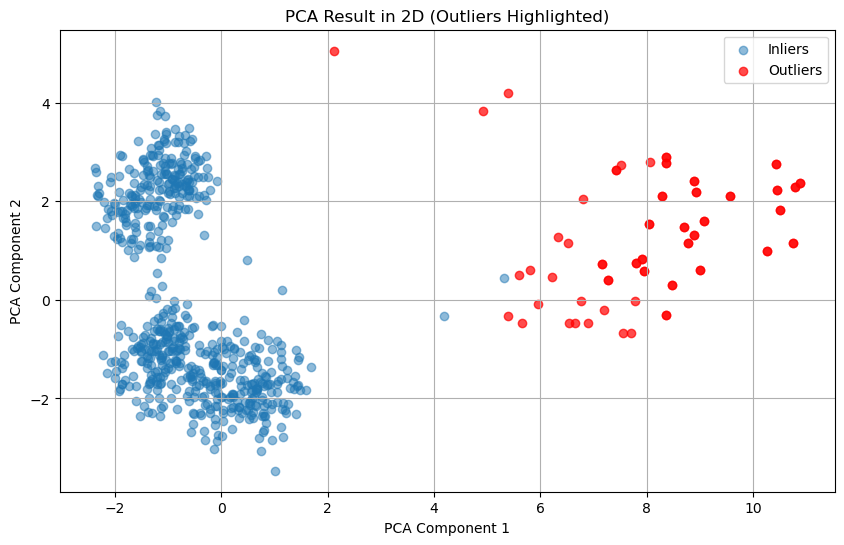

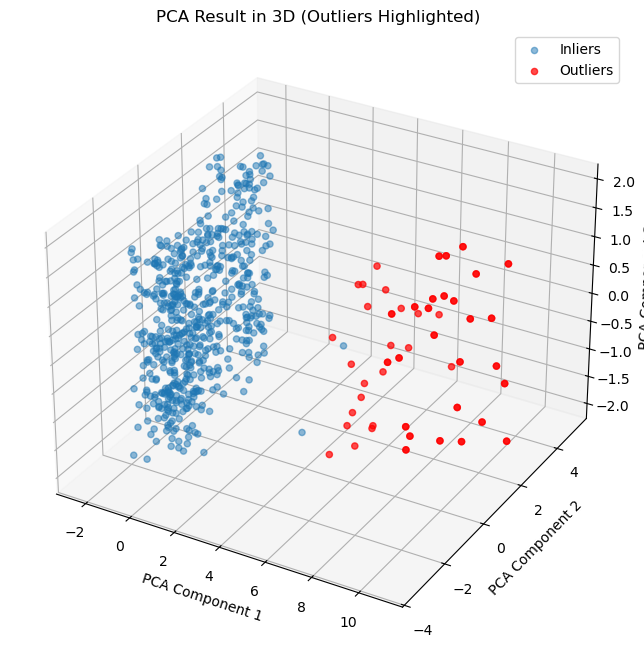

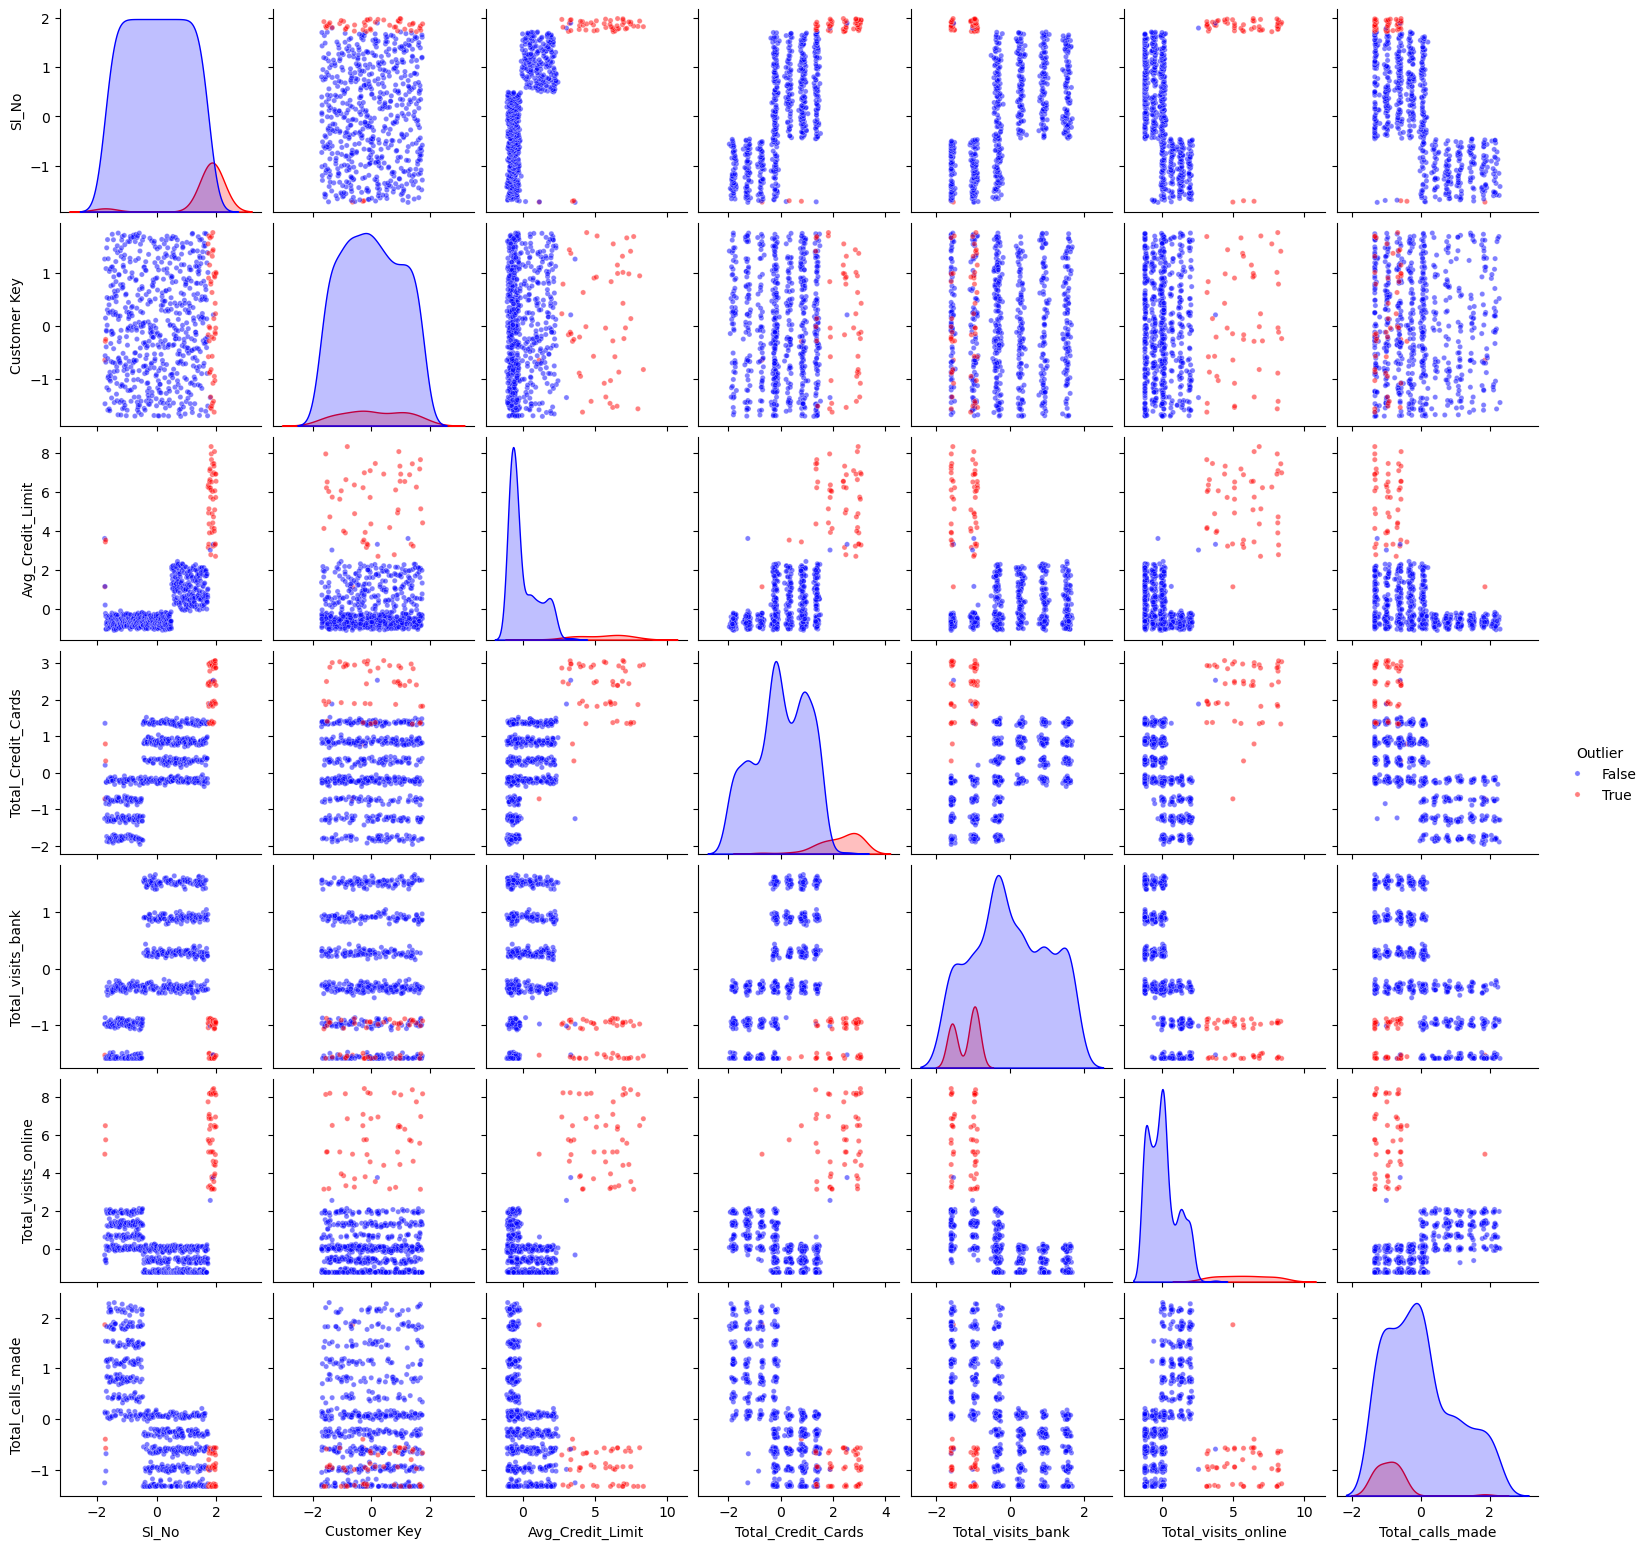

In [6]:
# Visualize PCA in with outliers in a different color
# PCA is fitted on both inliers and outliers (because it is for visualization purposes)
visualize_pca_2d_with_outliers(
    df_all_scaled, df_inliers_scaled, df_outliers_scaled
)
visualize_pca_3d_with_outliers(
    df_all_scaled, df_inliers_scaled, df_outliers_scaled
)

# Add a column to indicate outliers
df_all_scaled_with_outlier = df_all_scaled.copy()
df_all_scaled_with_outlier["Outlier"] = df_all_scaled.index.isin(
    df_cleaned_outliers.index
)

# Pairplots of all the data
# Inliers and outliers are plotted in different colors
sns.pairplot(
    df_all_scaled_with_outlier,
    hue="Outlier",
    palette={True: "red", False: "blue"},
    plot_kws={"s": 14, "alpha": 0.5},
    height=2.25,
)

From now on, we ignore the outliers and focus our efforts on the inliers.

### Clustering Algorithm 1: K-Means

#### Manual Review of Elbow Method and Silhouette Score Plot

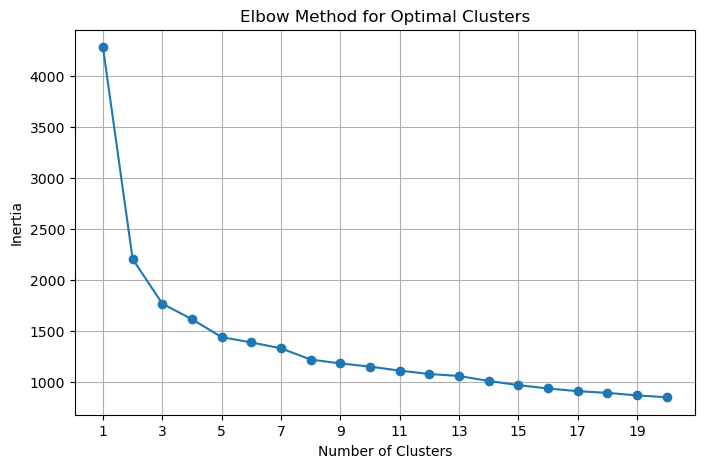

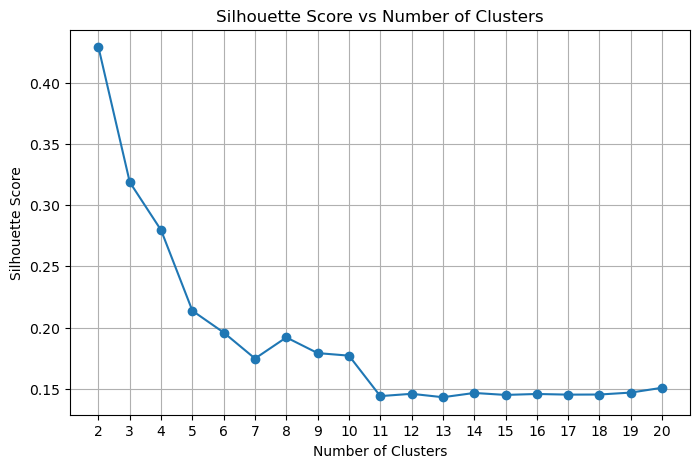

In [7]:
# Clustering Algorithm Type 1: K-Means

from sklearn.cluster import KMeans


def kmeans_clustering(df_scaled, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df_kmeans = df_scaled.copy()
    df_kmeans["Cluster"] = kmeans.fit_predict(df_kmeans)

    # Display the first few rows of the DataFrame with cluster labels
    display(df_kmeans.head())

    return df_kmeans


# Use elbow method to determine the optimal number of clusters

import matplotlib.pyplot as plt

estimator = KMeans(n_clusters=0, random_state=42)
elbow_method(df_inliers_scaled, estimator, max_clusters=20)
plot_clusters_vs_silhouette_score(
    df_inliers_scaled, estimator, max_clusters=20
)

We see that the elbow method and Silhouette Score plot both yield that the optimal number of clusters is 2, so we select that value.

#### Performing and Visualization of KMeans Clustering

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0 -1.745077      1.256534          3.612792           -1.253992   
1 -1.733747     -1.474686          1.145783            1.356411   
2 -1.728082     -0.567765          0.187120            0.209939   
3 -1.716753      0.142653         -0.244387           -0.736133   
4 -1.705423     -0.689967         -0.388721           -0.842915   

   Total_visits_bank  Total_visits_online  Total_calls_made  Cluster  
0          -0.986911            -0.315206         -1.257221        1  
1          -0.985444             0.629685          0.139937        0  
2          -0.872035            -0.592847          0.116400        0  
3          -1.596506            -0.609428          1.534543        0  
4          -1.596506            -0.542300         -1.025807        0

K-Means Clustering Result:


Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0 -1.745077      1.256534          3.612792           -1.253992   
1 -1.733747     -1.474686          1.145783            1.356411   
2 -1.728082     -0.567765          0.187120            0.209939   
3 -1.716753      0.142653         -0.244387           -0.736133   
4 -1.705423     -0.689967         -0.388721           -0.842915   

   Total_visits_bank  Total_visits_online  Total_calls_made  Cluster  
0          -0.986911            -0.315206         -1.257221        1  
1          -0.985444             0.629685          0.139937        0  
2          -0.872035            -0.592847          0.116400        0  
3          -1.596506            -0.609428          1.534543        0  
4          -1.596506            -0.542300         -1.025807        0

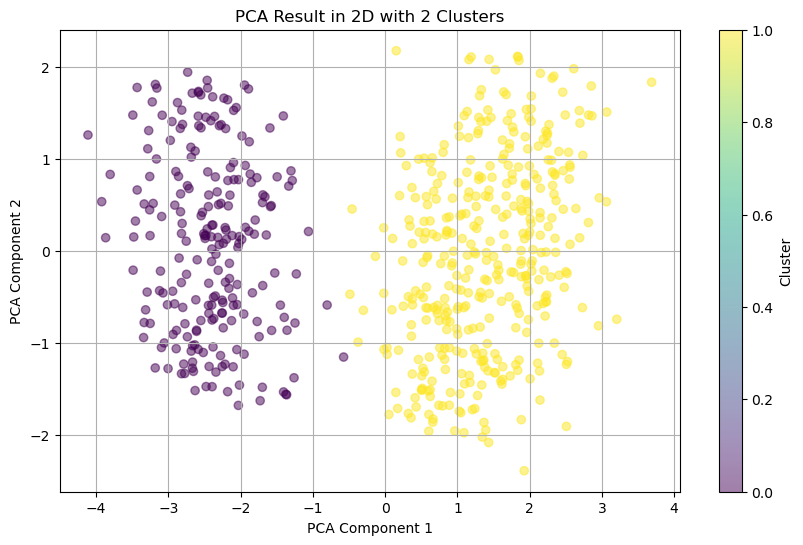

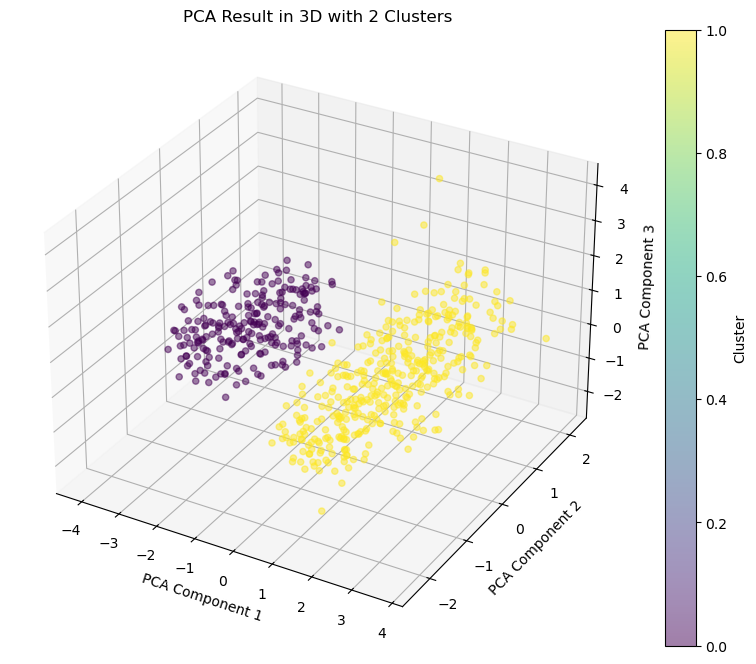

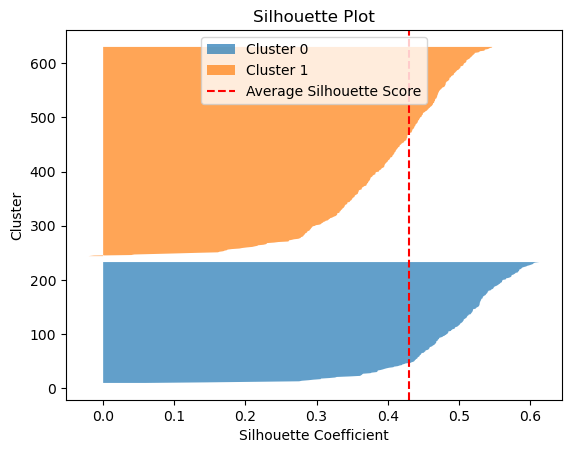

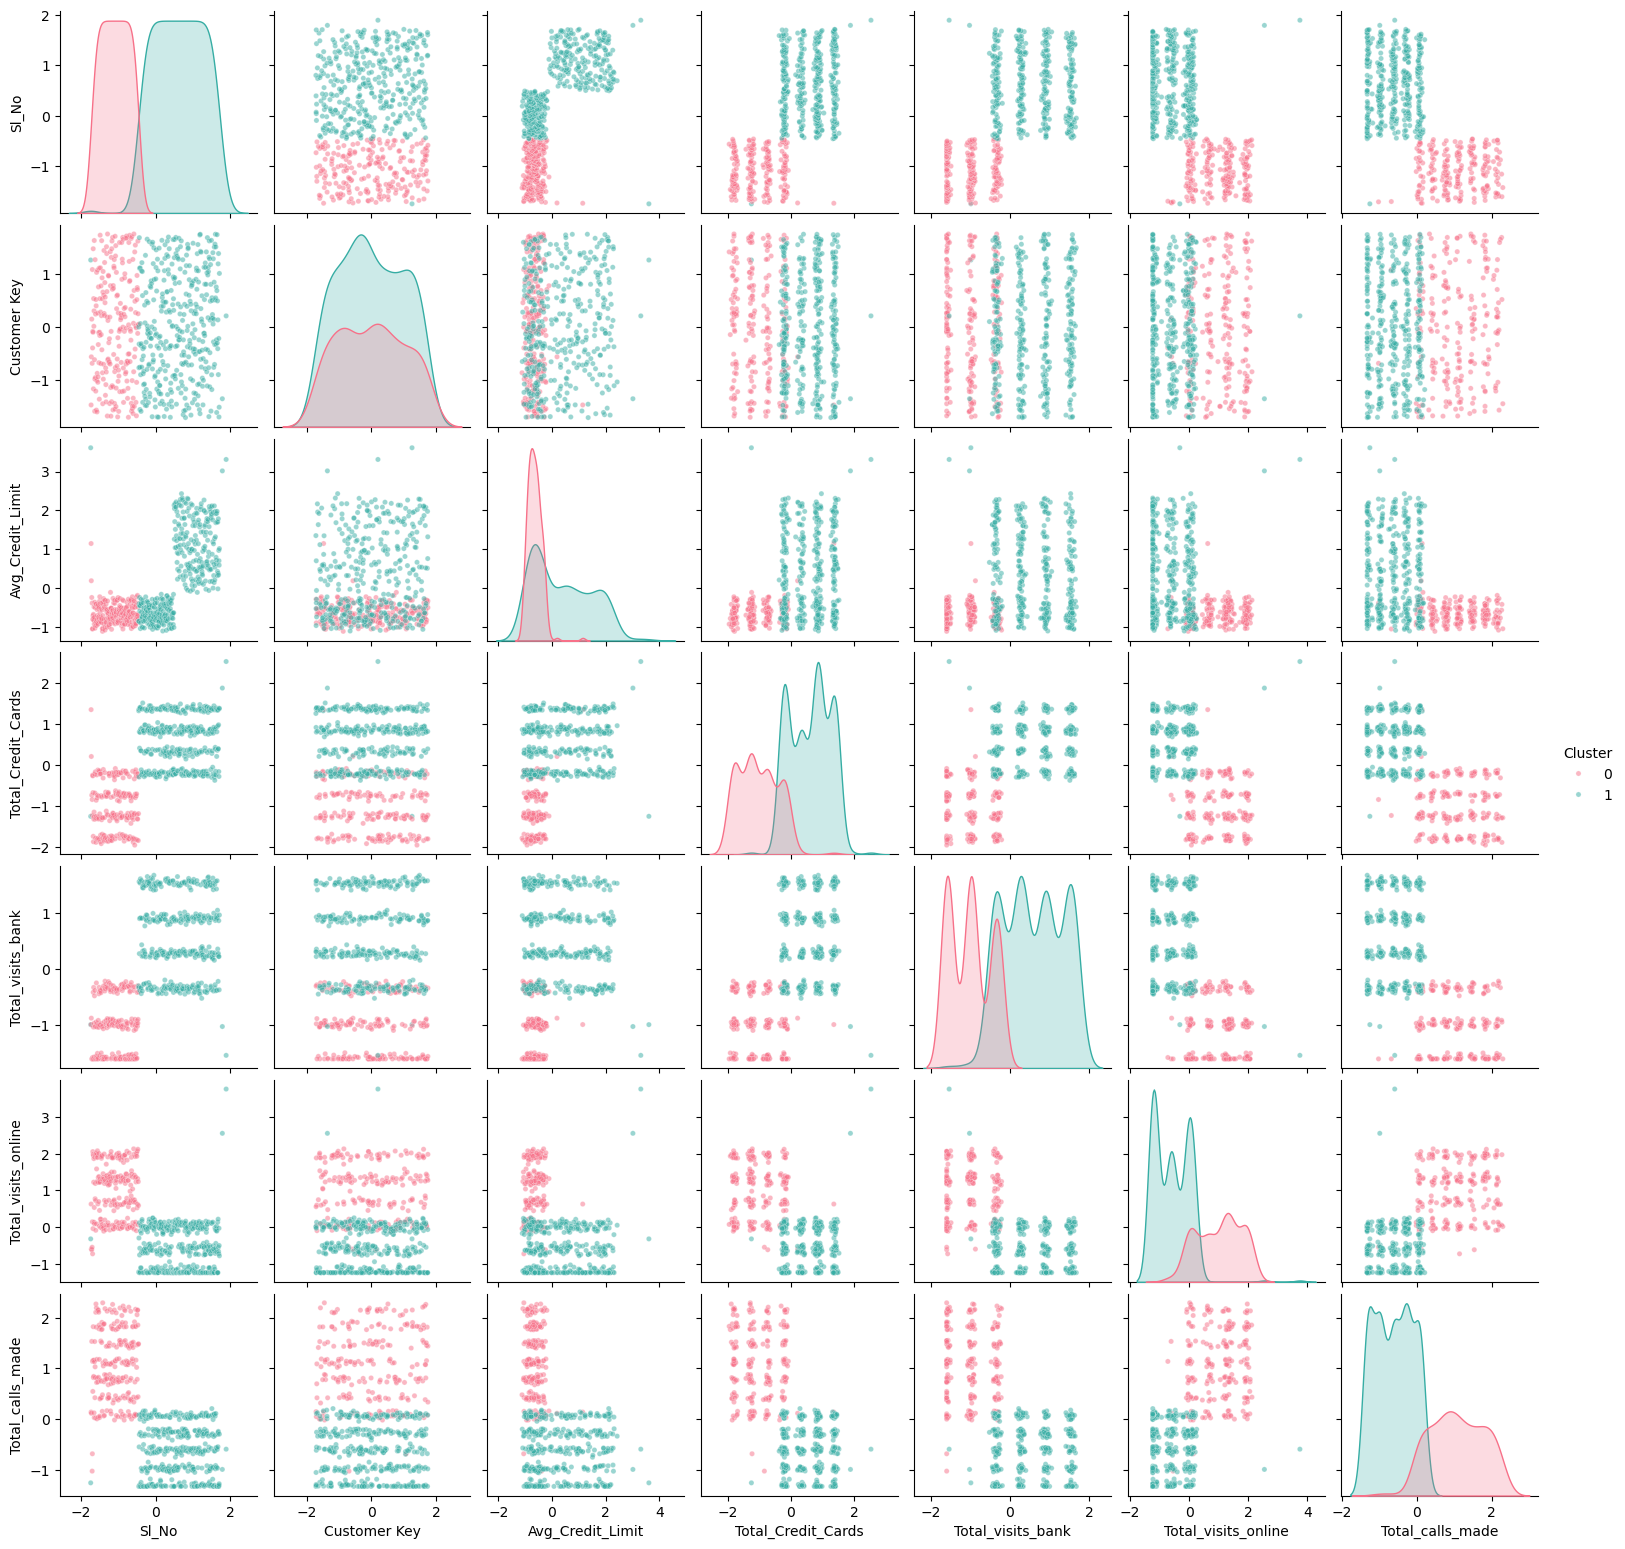

In [8]:
clusters = 2
df_kmeans = kmeans_clustering(df_inliers_scaled, n_clusters=clusters)

print("K-Means Clustering Result:")
display(df_kmeans.head())


# Display clusters in two colors on PCA plots
visualize_clusters_2d(df_kmeans, clusters)
visualize_clusters_3d(df_kmeans, clusters)

# Silhouette Plot

silhouette_plot(
    df_inliers_scaled,
    clusters,
    estimator=KMeans(n_clusters=clusters, random_state=42),
)

# Pairplots of K-Means clusters
sns.pairplot(
    df_kmeans,
    hue="Cluster",
    palette=sns.color_palette("husl", n_colors=clusters),
    plot_kws={"s": 14, "alpha": 0.5},
    height=2.25,
)

#### Silhouette and DBI Score for KMeans Clustering

In [9]:
# Silhouette Score for Hierarchical Clustering
silhouette_avg = silhouette_score(df_inliers_scaled, df_kmeans["Cluster"])
print(
    f"Silhouette Score for Hierarchical Clustering: {round(silhouette_avg, 4)}"
)

# Davies-Bouldin Index for K-Means Clustering
db_index = davies_bouldin_score(df_inliers_scaled, df_kmeans["Cluster"])
print(f"Davies-Bouldin Index for K-Means Clustering: {round(db_index, 4)}")

Silhouette Score for Hierarchical Clustering: 0.4291
Davies-Bouldin Index for K-Means Clustering: 0.9412


Not only do these clusters look great, but the scores are pretty good (a relatively low DBI and sufficient silhouette score)! Time for the next method.

### Clustering Algorithm 2: Hierarchical Clustering

#### Manual Review of Linkage-Clusters Plot "Elbow Method" and Silhouette Score Plot

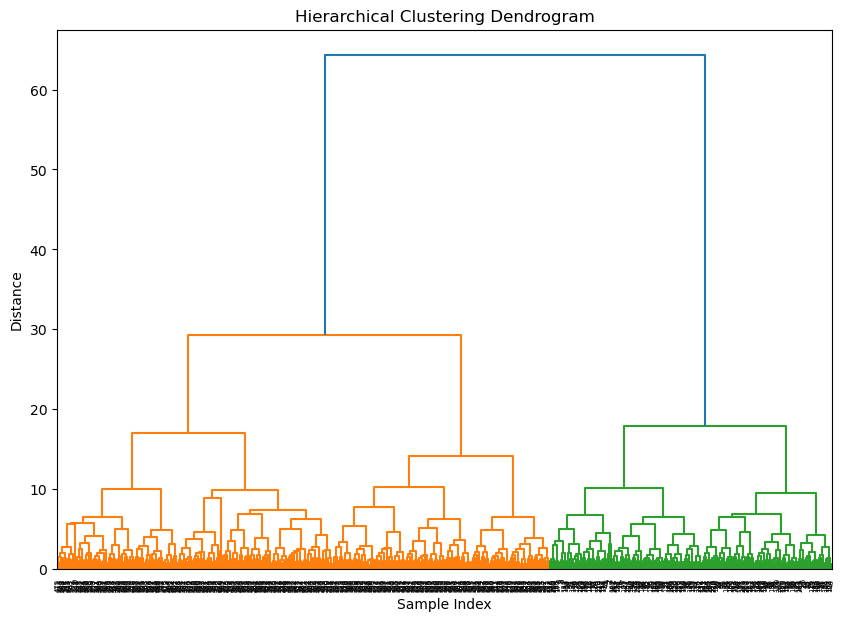

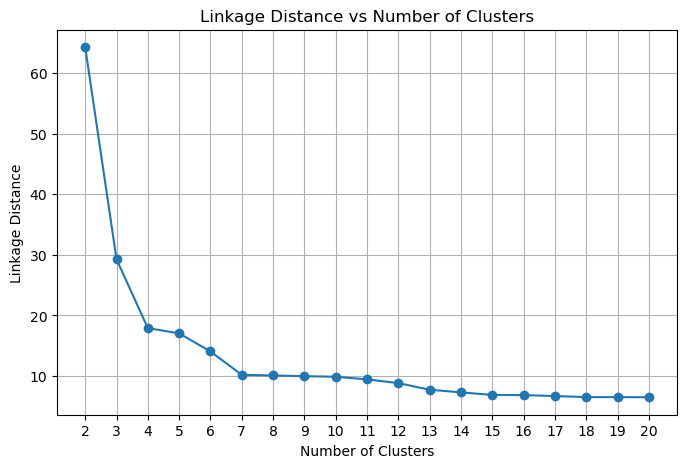

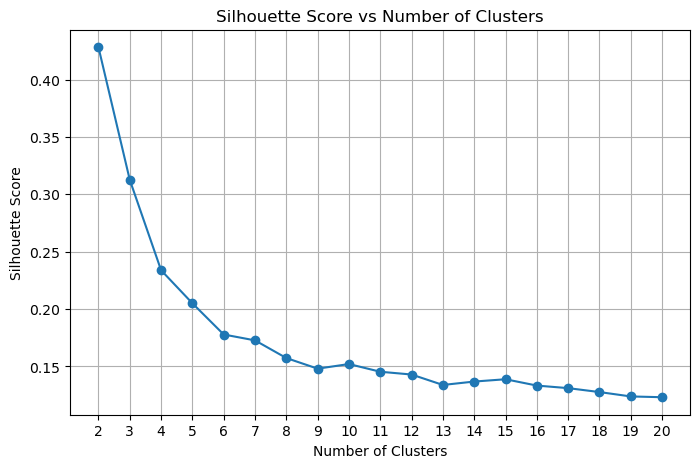

In [10]:
# Cluster using Hiearchical Clustering
from sklearn.cluster import AgglomerativeClustering


def hierarchical_clustering(df_scaled, n_clusters=3):
    # Fit Agglomerative Clustering
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    df_hierarchical = df_scaled.copy()
    df_hierarchical["Cluster"] = agglo.fit_predict(df_hierarchical)

    # Display the first few rows of the DataFrame with cluster labels
    display(df_hierarchical.head())

    return df_hierarchical


linked = linkage(df_inliers_scaled, method="ward")

# Plot dendrogram to visualize the hierarchical clustering
plot_dendrogram(df_inliers_scaled, linked)

# Plot clusters vs linkage distance
plot_clusters_vs_linkage_distance(df_inliers_scaled, linked, max_clusters=20)

plot_clusters_vs_silhouette_score(
    df_inliers_scaled,
    AgglomerativeClustering(n_clusters=0),
    max_clusters=20,
)

Even though the Linkage Distance "Elbow Plot" shows an elbow at 4 clusters, this type of elbow plot is much less reliable than the inertial version used in the context of KMeans because it is heavily influenced by subtle structure between clusters. Because the silhouette score shows a significant peak at 2 clusters, we will choose that value instead. 

#### Performing and Visualizing Hierarchical Clustering

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0 -1.745077      1.256534          3.612792           -1.253992   
1 -1.733747     -1.474686          1.145783            1.356411   
2 -1.728082     -0.567765          0.187120            0.209939   
3 -1.716753      0.142653         -0.244387           -0.736133   
4 -1.705423     -0.689967         -0.388721           -0.842915   

   Total_visits_bank  Total_visits_online  Total_calls_made  Cluster  
0          -0.986911            -0.315206         -1.257221        0  
1          -0.985444             0.629685          0.139937        1  
2          -0.872035            -0.592847          0.116400        1  
3          -1.596506            -0.609428          1.534543        1  
4          -1.596506            -0.542300         -1.025807        1

Hierarchical Clustering Result:


Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0 -1.745077      1.256534          3.612792           -1.253992   
1 -1.733747     -1.474686          1.145783            1.356411   
2 -1.728082     -0.567765          0.187120            0.209939   
3 -1.716753      0.142653         -0.244387           -0.736133   
4 -1.705423     -0.689967         -0.388721           -0.842915   

   Total_visits_bank  Total_visits_online  Total_calls_made  Cluster  
0          -0.986911            -0.315206         -1.257221        0  
1          -0.985444             0.629685          0.139937        1  
2          -0.872035            -0.592847          0.116400        1  
3          -1.596506            -0.609428          1.534543        1  
4          -1.596506            -0.542300         -1.025807        1

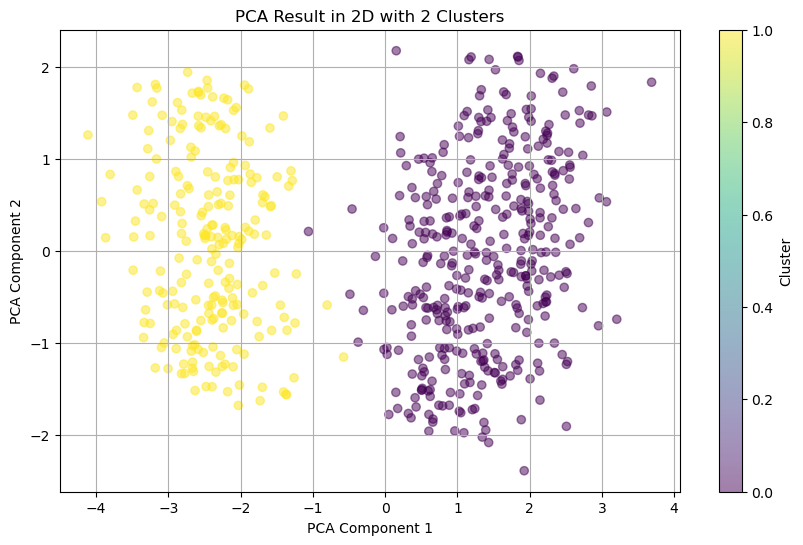

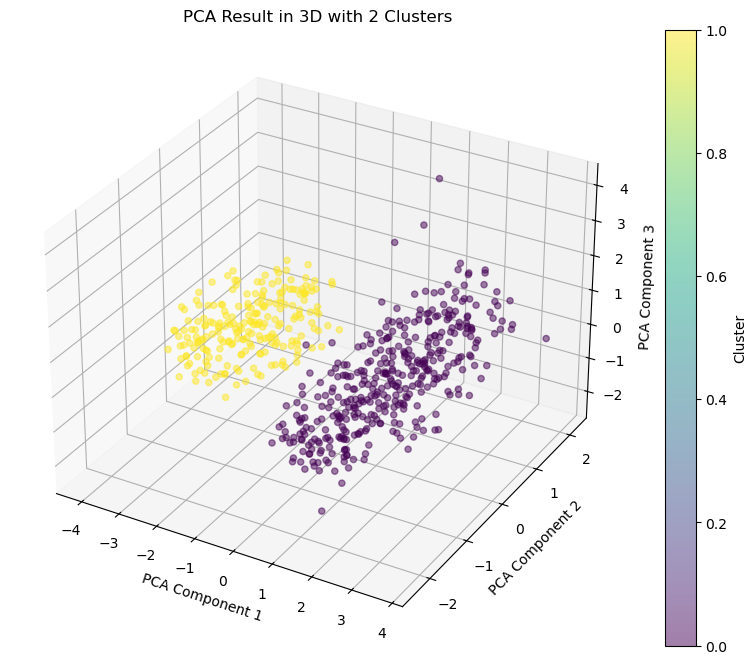

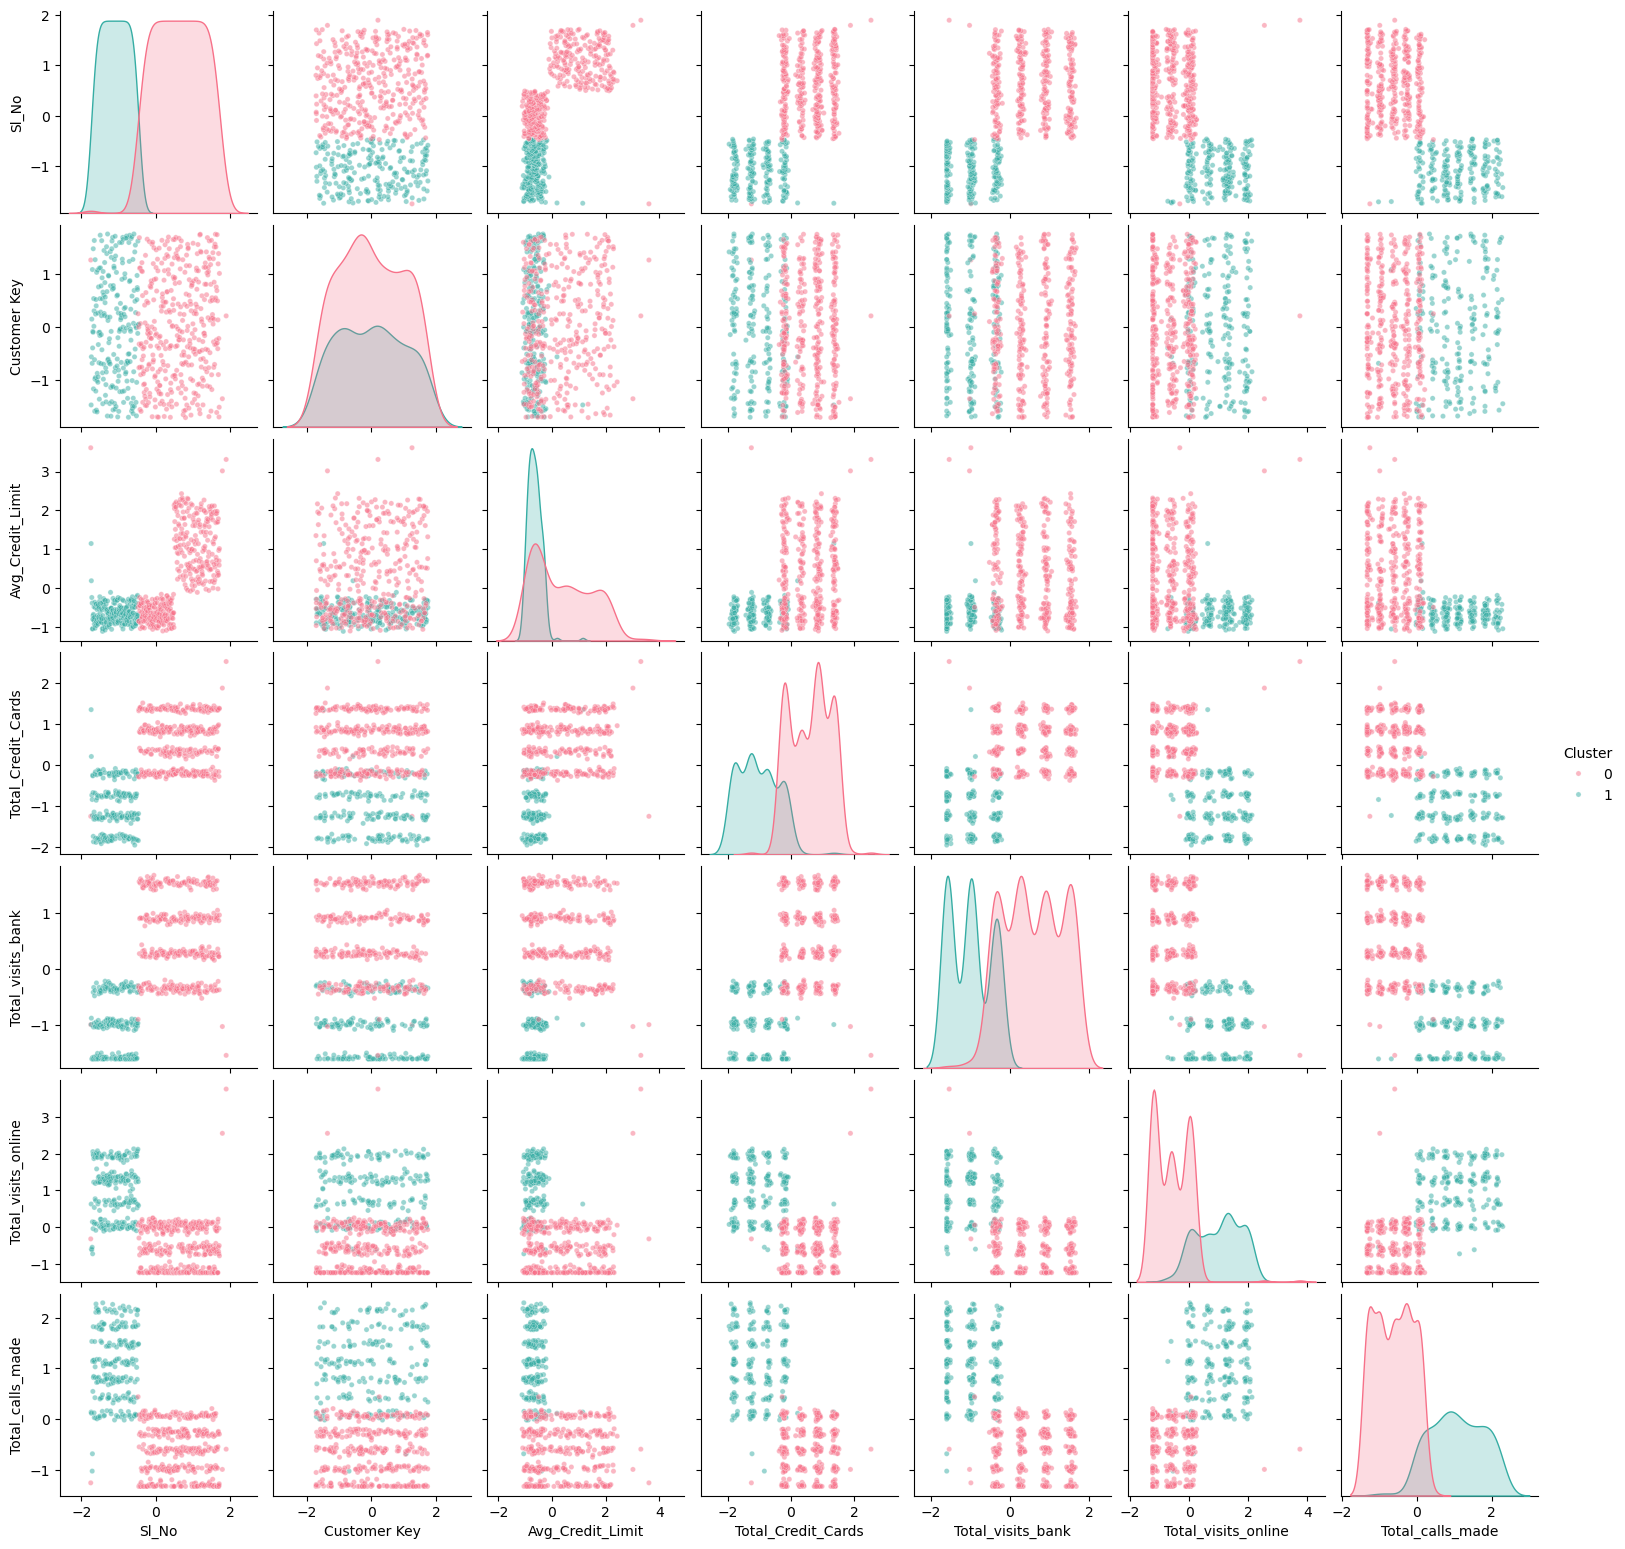

In [11]:
clusters = 2
# Perform hierarchical clustering
df_hierarchical = hierarchical_clustering(
    df_inliers_scaled, n_clusters=clusters
)
print("Hierarchical Clustering Result:")
display(df_hierarchical.head())

# Visualize clusters in 2D and 3D for hierarchical clustering
visualize_clusters_2d(df_hierarchical, clusters)
visualize_clusters_3d(df_hierarchical, clusters)

# Pairplots of Hierarchical Clustering clusters
sns.pairplot(
    df_hierarchical,
    hue="Cluster",
    palette=sns.color_palette("husl", n_colors=clusters),
    plot_kws={"s": 14, "alpha": 0.5},
    height=2.25,
)

In [12]:
# Silhouette Score for Hierarchical Clustering
silhouette_avg = silhouette_score(
    df_inliers_scaled, df_hierarchical["Cluster"]
)
print(
    f"Silhouette Score for Hierarchical Clustering: {round(silhouette_avg, 4)}"
)

# Davies-Bouldin Index for Hierarchical Clustering
db_index = davies_bouldin_score(df_inliers_scaled, df_hierarchical["Cluster"])
print(
    f"Davies-Bouldin Index for Hierarchical Clustering: {round(db_index, 4)}"
)

Silhouette Score for Hierarchical Clustering: 0.4283
Davies-Bouldin Index for Hierarchical Clustering: 0.9417


Again, these cluster graphs and scores look pretty good. Now, let's compare the cluster assignments from both algorithms.

In [13]:
# Compare cluster assignments between K-Means and Hierarchical Clustering with ARI and NMI
def compare_cluster_assignments(df_kmeans, df_hierarchical):
    ari = adjusted_rand_score(df_kmeans["Cluster"], df_hierarchical["Cluster"])
    nmi = normalized_mutual_info_score(
        df_kmeans["Cluster"], df_hierarchical["Cluster"]
    )
    return ari, nmi


ari, nmi = compare_cluster_assignments(df_kmeans, df_hierarchical)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

Adjusted Rand Index (ARI): 0.9934
Normalized Mutual Information (NMI): 0.9833


These score are very close to 1, demonstrating that the algorithms made very similar assignments!

According to the scores returned, it appears that both the KMeans and Hierarchical clustering algorithms both functioned effectively and yielded similar results. They segmented the data appearingly well, with two large clusters. 

Outlier detection and feature scaling were completely straightforward on this dataset, using the 1.5xIQR rule individually for each column, and standard scaling, respectively.

Silhouette and Davies-Bouldin Scores aided in determining the effectiveness of clustering algorithms in this analysis, which is a crucial assessment measure to have. It's similar to the test score received during supervised training: used to help you understand how accurate your model is. One way they are different, however, is they are not percentages, which is a critical distinction. 